c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [0/1000], Loss: 2988.1057
Epoch [100/1000], Loss: 370.0400
Epoch [200/1000], Loss: 365.1241
Epoch [300/1000], Loss: 363.4636
Epoch [400/1000], Loss: 360.0553
Epoch [500/1000], Loss: 358.3352
Epoch [600/1000], Loss: 357.7488
Epoch [700/1000], Loss: 357.0829
Epoch [800/1000], Loss: 355.8008
Epoch [900/1000], Loss: 355.5234


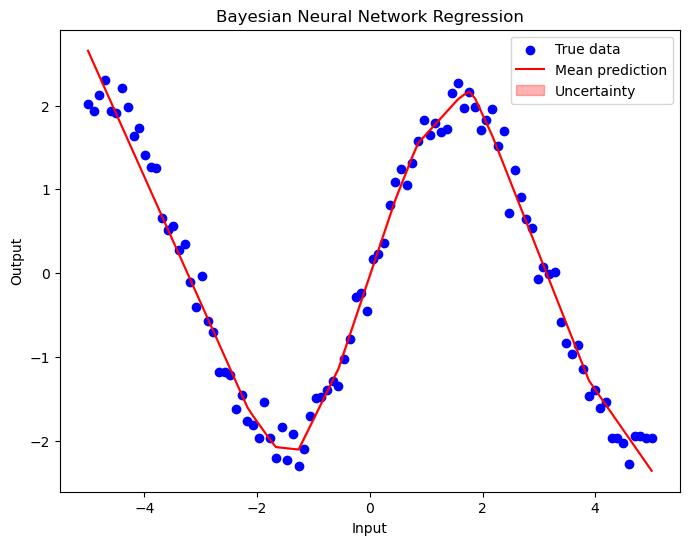

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Gnerate toy data
np.random.seed(42)
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = 2 * np.sin(X) + np.random.normal(0, 0.2, size=X.shape)

# Conv data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define the BNN 
class BayesianNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=50):
        super(BayesianNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        # Define the Bayesian layers
        self.layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights with Gaussian priors
        self.layer1.weight.data.normal_(0, 0.1)
        self.layer1.bias.data.fill_(0)
        self.layer2.weight.data.normal_(0, 0.1)
        self.layer2.bias.data.fill_(0)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# likelihood (Gaussian)
def likelihood(y_pred, y_true, sigma=0.2):
    return torch.distributions.normal.Normal(y_pred, sigma).log_prob(y_true).sum()

# prior (Gaussian)
def prior(model, sigma=1):
    log_prior = 0
    for param in model.parameters():
        log_prior += torch.distributions.normal.Normal(0, sigma).log_prob(param).sum()
    return log_prior

# Dposterior
def posterior(model, sigma=0.1):
    log_posterior = 0
    for param in model.parameters():
        log_posterior += torch.distributions.normal.Normal(param, sigma).log_prob(param).sum()
    return log_posterior

#  loss function as  negative log posterior
def loss_function(y_pred, y_true, model):
    nll = - (likelihood(y_pred, y_true) + prior(model) - posterior(model))
    return nll

# Initialize the Bayesian Neural Network model
bnn_model = BayesianNN(input_dim=1, output_dim=1)

# 
optimizer = optim.Adam(bnn_model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = bnn_model(X_tensor)
    loss = loss_function(y_pred, y_tensor, bnn_model)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# predictions with uncertainty
with torch.no_grad():
    bnn_model.eval()
    y_pred = bnn_model(X_tensor)
    samples = [bnn_model(X_tensor) for _ in range(1000)]
    mean = torch.mean(torch.stack(samples), dim=0)
    std = torch.std(torch.stack(samples), dim=0)


plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='True data', color='blue')
plt.plot(X, mean, label='Mean prediction', color='red')
plt.fill_between(X.squeeze(), (mean - 2 * std).squeeze(), (mean + 2 * std).squeeze(), alpha=0.3, color='red', label='Uncertainty')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Bayesian Neural Network Regression')
plt.legend()
plt.show()

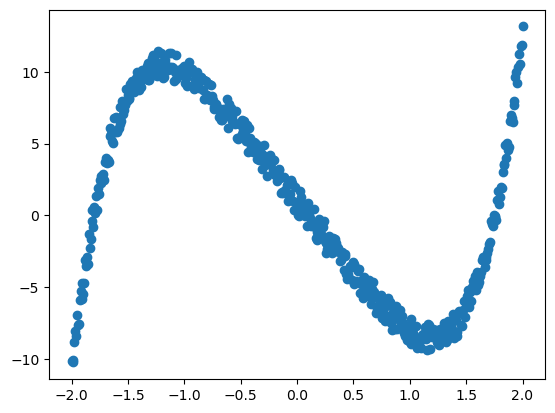

- MSE : 1.91, KL : 11.59


Text(0, 0.5, 'y')

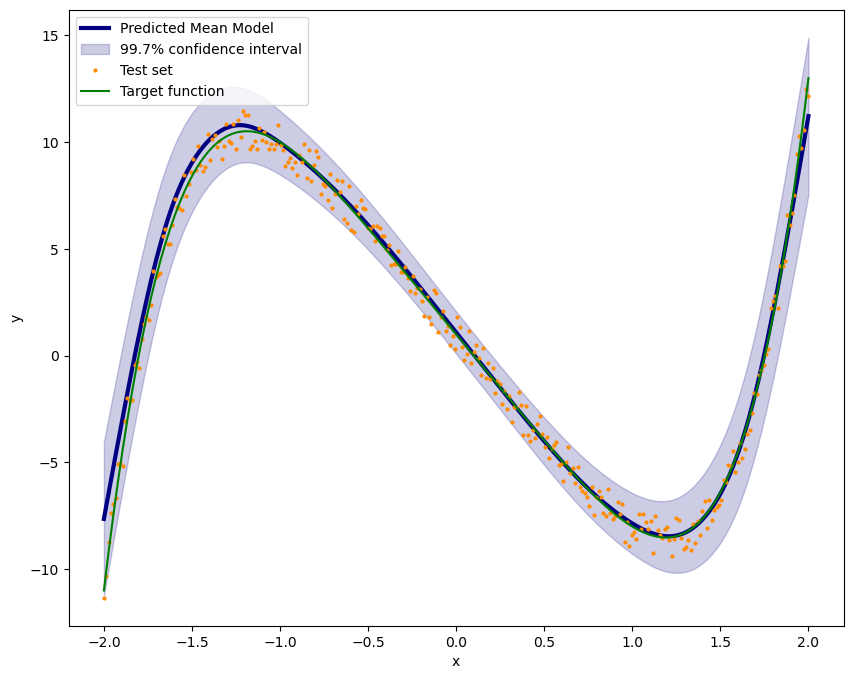

In [3]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

x = torch.linspace(-2, 2, 500)
y = x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

def clean_target(x):
    return x.pow(5) -10* x.pow(1)+1
def target(x):
    return x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

x_test = torch.linspace(-2, 2, 300)
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(10,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
#plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test.data.numpy(),clean_target(x_test).data.numpy(),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

In [81]:
import pandas as pd 

adt = pd.read_csv("../Warping-tests/engineered_data/assay_desurveyed_transformed_Mlith_domain.csv")
domained = pd.read_csv('../Warping-tests/engineered_data/blockmodel_domained_NN.csv')

columns_to_replace = adt.columns[17:31]
adt[columns_to_replace] = adt[columns_to_replace].replace(0, np.nan)
mineral = 'Cu_pct'
adt_Cu= adt.loc[:,["HOLEID", 'EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf', mineral]]

adt_Cu = adt_Cu.dropna(subset=[mineral])

counts = adt['HOLEID'].value_counts()
mask = adt['HOLEID'].isin(counts[counts > 40].index) & ~adt['Cu_pct'].isna()
result = adt[mask]
adt_Cu2 = adt_Cu

In [146]:
hole = 'OTD461'
adt_Cu = adt_Cu2.loc[adt_Cu2['HOLEID'] == hole]
x = adt_Cu[['EAST_mid_tf','NORTH_mid_tf', 'RL_mid_tf']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = adt_Cu[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(adt_Cu),3)
x = x[:,2].reshape(-1,1)

In [147]:
x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)


In [148]:
# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.5 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[test_indices]
y_test = y[test_indices]

In [154]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=1, prior_sigma=0.1, in_features=1, out_features=10),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=1, prior_sigma=0.1, in_features=10, out_features=1),
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 0.70, KL : 61.02


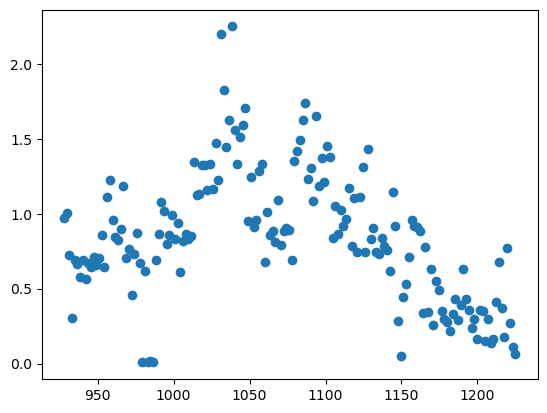

Text(0, 0.5, 'y')

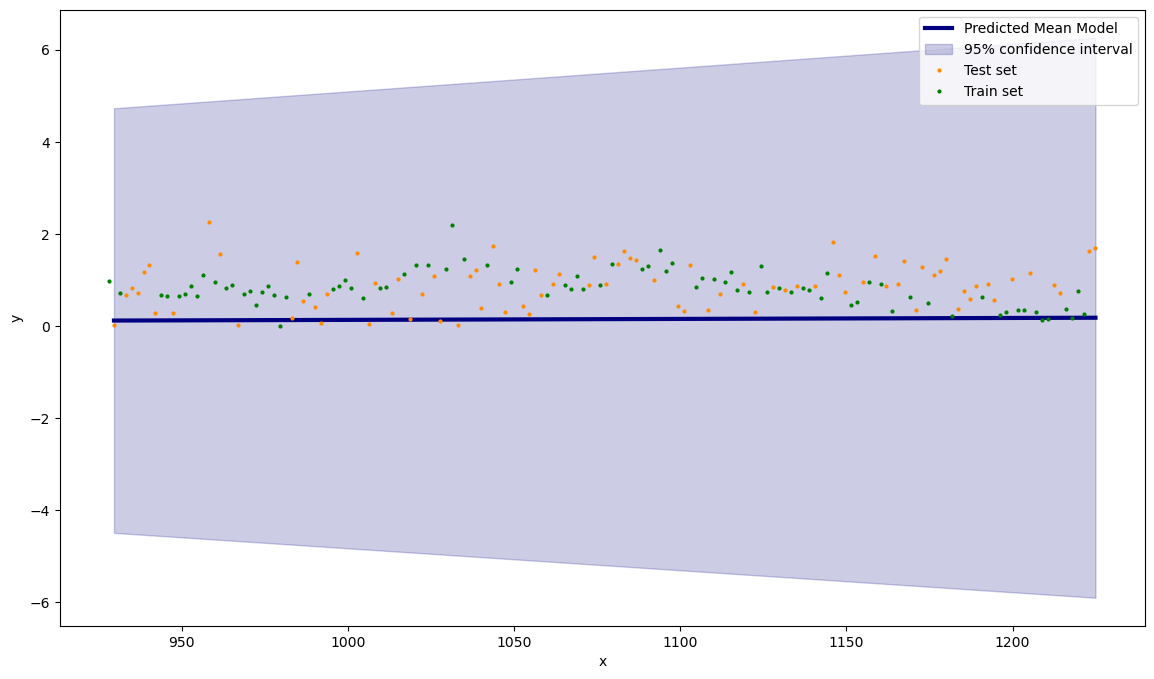

In [155]:
models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

x_test.data.numpy().T[0].sort()



plt.figure(figsize=(14,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0],mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')
#plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_train.data.numpy(),y_train.data.numpy(),'.',color='green',markersize=4,label='Train set')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

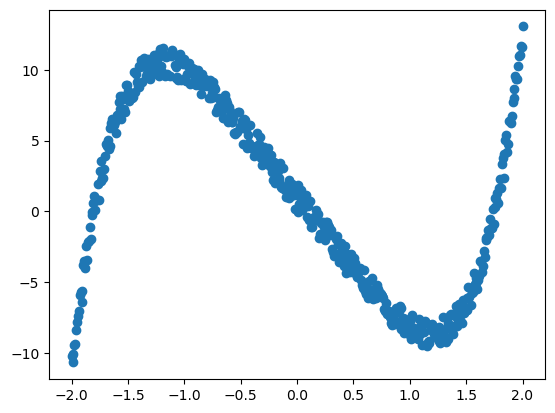

KeyboardInterrupt: 

In [78]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

x = torch.linspace(-2, 2, 500)
y = x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

def clean_target(x):
    return x.pow(5) -10* x.pow(1)+1
def target(x):
    return x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

x_test = torch.linspace(-2, 2, 300)
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(10,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
#plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test.data.numpy(),clean_target(x_test).data.numpy(),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')